In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import json
import yfinance as yf
import matplotlib.pyplot as plt

# calculations
def getLogReturnByStockPrice(df) -> pd.DataFrame:
    df1 = np.log(1+df.pct_change())
    return df1
def portfolioReturn(df, weights):
    return np.dot(df.mean(), weights)

def portfolioStd(df, weights, year=250):
    return np.dot(np.dot(df.cov(), weights), weights) ** (1/2) * np.sqrt(year)

def weightsCreator(df):
    rand = np.random.random(len(df.columns))
    rand /= rand.sum()
    return rand

def getWeightsByMontecarlo(stock_price_df, num=10000):
    df = getLogReturnByStockPrice(stock_price_df)
    returns = []
    stds = []
    w = []
    for _ in range(num):
        weights = weightsCreator(df)
        
        returns.append(portfolioReturn(df, weights)) # weighted return
        stds.append(portfolioStd(df, weights, 250)) # portfolio stadnard deviation vector calc
        w.append(weights)

    min_std = min(stds)
    index_min = stds.index(min_std)
    return w[index_min]

def getDF(codename_list, start_time, end_time):
    df = pd.DataFrame()
    for codename in codename_list:
            try:
                symbol = tw_stock_symbol_code[codename]
            except:
                symbol = tw_stock_symbol_code[check[codename]]
            data = pd.read_csv(f"../DB/TW/{symbol}.csv", index_col="Date")
            data_adj = data.loc[(data.index >= start_time) & (data.index <= end_time)]["Adj Close"]
            data_adj.name = symbol
            df = pd.concat([df, data_adj], axis=1)

    df.dropna(inplace=True)
    return df

def getNavSeries(df_now_for_nav, nav_current = 1):
    df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    nav = nav_series.iloc[-1]
    return nav_series, nav

fitting_num = 100
start="2017-09-27"
end="2023-12-30"


# 前置資料: 股票代號中文對照(tw_stock_symbol_code)、各期成分股(data)、換股時間(time_start_end)
location = "../0056成份股季調整生效日期.xlsx"
time_df = pd.read_excel(location)
time_start_end = time_df.iloc[:, :2]

# 有對照錯誤的股票中文名稱
check = {'聚陽實業':'聚陽',
         "矽品": "矽品精密",
         "仁寶電腦":"仁寶",
         "群創光電":"群創",
         "微星科技":"微星",
         "智邦科技":"智邦",
         "群光電子":"群光",
         "聯強國際":"聯強",
         "創見資訊":"創見"
}

with open("../DB/0056_Ingred.json", "r", encoding="UTF-8") as f:
    data = json.load(f)

with open("../DB/tw_stock_symbol_code.json", "r") as f:
    tw_stock_symbol_code = json.load(f)

nav_current = 1
nav_all = pd.Series()
seasonal_return = {}
seasonal_std = {}
sample = ['17Q4', "18Q1"]
list_ = list(data.keys())
for i, season in enumerate(list_):
    print(season)
    start_time = datetime.strftime(time_start_end.iloc[i, 0], "%Y-%m-%d")
    end_time = datetime.strftime(time_start_end.iloc[i, 1], "%Y-%m-%d")
    if i == 0:
        start_time_var = "2017-06-26"
        end_time_var = "2017-09-26"
    else:
        start_time_var = datetime.strftime(time_start_end.iloc[i-1, 0], "%Y-%m-%d")
        end_time_var = datetime.strftime(time_start_end.iloc[i-1, 1], "%Y-%m-%d")

    # print(var_dict)
    df_previous_for_weighting = getDF(data[season], start_time_var, end_time_var)
    weighting = getWeightsByMontecarlo(df_previous_for_weighting, fitting_num)
    print(f"max weighing: {max(weighting)}")
    df_now_for_nav = getDF(data[season], start_time, end_time)
    
    nav_series, nav_current = getNavSeries(df_now_for_nav, nav_current)
    nav_all = pd.concat([nav_all, nav_series], axis=0)

    # others
    seasonal_return[season] = nav_series
    seasonal_std[season] = np.std(nav_all)*np.sqrt(len(nav_series))
# plt.plot(nav_all, label='nav_new')

# zero56 = yf.download("0056.TW", start=start, end=end)
# zero56_cumprod = (1 + zero56['Adj Close'].pct_change()).cumprod()
# zero56_cumprod = zero56_cumprod.fillna(1)
# zero56_cumprod = pd.Series(zero56_cumprod, index=nav_all.index)
# plt.plot(zero56_cumprod, color='red', label='0056 Origin')

# plt.title("0056 vs Minimum Variance 0056")
# plt.legend(loc='upper left')
# plt.xticks()
# plt.plot()

FileNotFoundError: [Errno 2] No such file or directory: '../0056成份股季調整生效日期.xlsx'

In [6]:
import numpy as np
import statsmodels.api as sm

# Example returns data for portfolio and benchmark index
portfolio_returns = np.array([0.01, 0.02, -0.03, 0.01, 0.02])
benchmark_returns = np.array([0.015, 0.02, -0.01, 0.015, 0.025])

# Add a constant to the independent variable (benchmark returns)
X = sm.add_constant(benchmark_returns)

# Fit linear regression model
model = sm.OLS(portfolio_returns, X)
results = model.fit()

# Get alpha and beta from the regression results
alpha = results.params[0]
beta = results.params[1]

print("Alpha:", alpha)
print("Beta:", beta)


Alpha: -0.013767123287671226
Beta: 1.5205479452054795


total strat return: 3.212286092815634
total 00713 return: 2.423802805450387
total 0056 return: 2.206653451131824
annual strat return: 0.18141377703945816
annual 00713 return: 0.13482314145741747
annual 0056 return: 0.11970824523910073


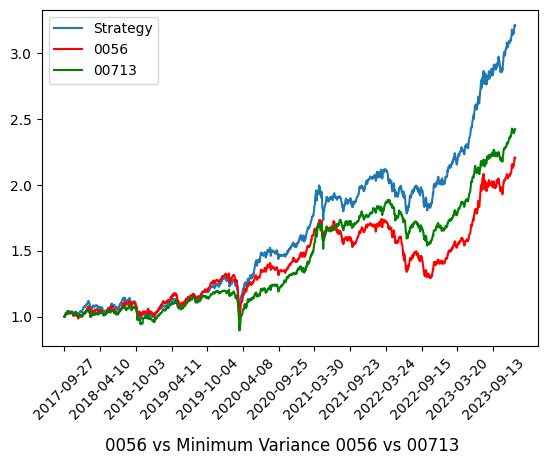

<Figure size 640x480 with 0 Axes>

In [2]:
zero56 = yf.download("0056.TW", start=start, end=end, progress=False)
zero56_cumprod = (1 + zero56['Adj Close'].pct_change()).cumprod()
zero56_cumprod = zero56_cumprod.fillna(1)
zero56_cumprod = pd.Series(zero56_cumprod*1, index=nav_all.index)

zero713 = yf.download("00713.TW", start=start, end=end, progress=False)
zero713_cumprod = (1 + zero713['Adj Close'].pct_change()).cumprod()
zero713_cumprod = zero713_cumprod.fillna(1)
zero713_cumprod = pd.Series(zero713_cumprod*1, index=nav_all.index)


print("total strat return:", nav_all.iloc[-1])
print("total 00713 return:", zero713_cumprod.iloc[-1])
print("total 0056 return:", zero56_cumprod.iloc[-1])

print("annual strat return:", (nav_all.iloc[-1])**(1/7) - 1)
print("annual 00713 return:", (zero713_cumprod.iloc[-1])**(1/7) - 1)
print("annual 0056 return:", (zero56_cumprod.iloc[-1])**(1/7) - 1)



plt.plot(nav_all, label='Strategy')
plt.plot(zero56_cumprod, color='red', label='0056')
plt.plot(zero713_cumprod, color="green", label='00713')
# plt.title("0056 vs Minimum Variance 0056 vs 00713")

plt.subplots_adjust(top=0.9, bottom=0.2)
plt.suptitle("0056 vs Minimum Variance 0056 vs 00713", y=0.01)

plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.xticks(nav_all.index[::120])
plt.plot()
plt.show()
plt.savefig("v1_comp.png")



In [38]:
# calculating tables
def calculating_alpha_beta(nav_all, risk_free_rate_annual=0.03):
    ret = nav_all.pct_change()



    vol = ret.std()*np.sqrt(252)
    vol_sortino = ret[ret < 0].std()*np.sqrt(252)
    avg = ret.mean()*252

    var = vol**2
    std = vol

    sharpe = (avg - risk_free_rate_annual)/vol
    sortino = (avg - risk_free_rate_annual)/vol_sortino


    print("Sortino Ratio: {:.6f}".format(sortino))
    print("Sharpe Ratio: {:.6f}".format(sharpe))
    print("variance: ", var)
    print("std: ", std)
print("=====Strategy=====")
calculating_alpha_beta(nav_all)
print("=====0056=====")
calculating_alpha_beta(zero56_cumprod)
print("=====00713=====")
calculating_alpha_beta(zero713_cumprod)

=====Strategy=====
Sortino Ratio: 1.533640
Sharpe Ratio: 1.254861
variance:  0.01921747808108756
std:  0.1386271188515709
=====0056=====
Sortino Ratio: 0.965426
Sharpe Ratio: 0.810622
variance:  0.018823116221867827
std:  0.13719736229923601
=====00713=====
Sortino Ratio: 1.171695
Sharpe Ratio: 1.018205
variance:  0.015062799210441917
std:  0.1227305960648848


50


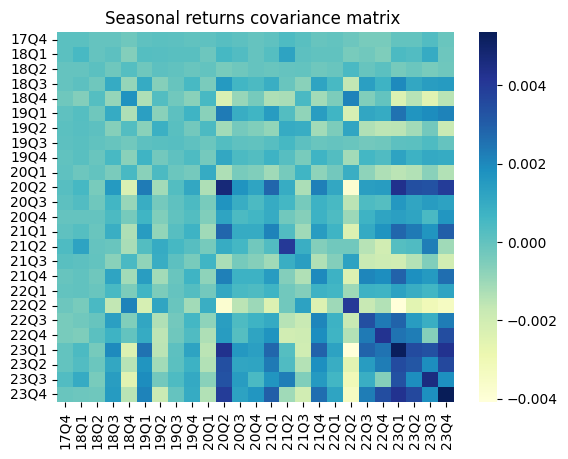

In [133]:
import seaborn as sns

k = list(seasonal_return.values())
max_len = 200
for i in k:
    length = len(i)
    if length <= max_len:
        max_len = length
print(max_len)
for i, season in enumerate(k):
    k[i] = season[:max_len]
# # np.cov(k)
sns.heatmap(np.cov(k), cmap="YlGnBu",xticklabels=list_, yticklabels=list_, annot=False)
plt.title("Seasonal returns covariance matrix")
plt.savefig("charts/seasonal_cav_heatmap.png")

MDD strat: -0.255024285651976
MDD 0056: -0.2585633416486286
MDD 00713: -0.257995270268389


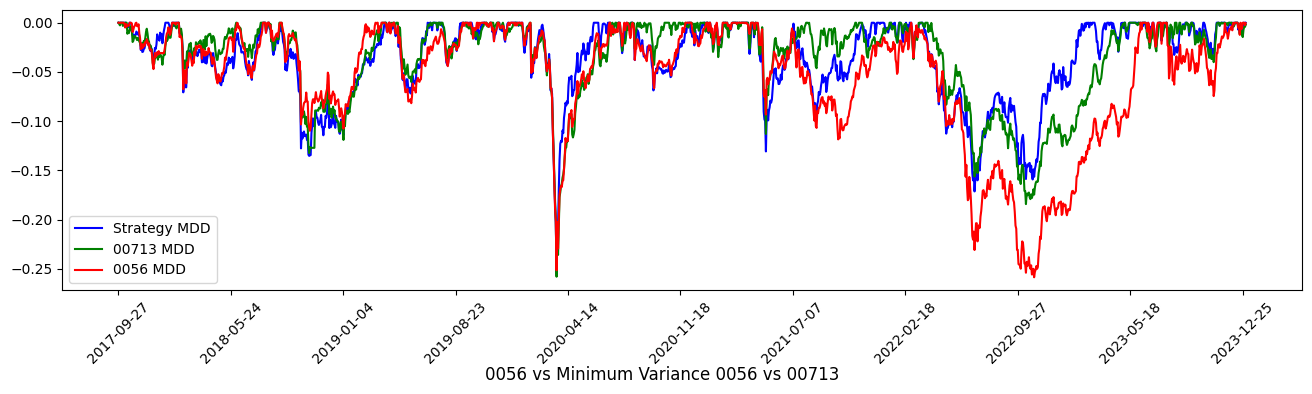

In [54]:
def from_nav_to_mdd(nav_all):

    Roll_Max = nav_all.rolling(len(nav_all), min_periods=1).max()
    Daily_Drawdown = nav_all/Roll_Max - 1.0
    
    Max_Daily_Drawdown = Daily_Drawdown.rolling(len(nav_all), min_periods=1).min()

    return Daily_Drawdown, min(Max_Daily_Drawdown)
# Max_Daily_Drawdown.plot()
zero713_cumprod
MDD, MDD_max_strat = from_nav_to_mdd(nav_all)
MDD_0056, MDD_max_0056 = from_nav_to_mdd(zero56_cumprod)
MDD_00713, MDD_max_00713 = from_nav_to_mdd(zero713_cumprod)

print("MDD strat:", MDD_max_strat)
print("MDD 0056:", MDD_max_0056)
print("MDD 00713:", MDD_max_00713)

plt.figure(figsize=(16, 4))
plt.plot(MDD, label="Strategy MDD", color='blue')
plt.plot(MDD_00713, label="00713 MDD", color='green')
plt.plot(MDD_0056, label='0056 MDD', color='red')

plt.xticks(MDD.index[::len(MDD) // 10])
plt.xticks(rotation=45)

plt.subplots_adjust(top=0.9, bottom=0.2)
plt.suptitle("0056 vs Minimum Variance 0056 vs 00713", y=0.01)

plt.legend()
plt.show()

In [53]:
# 滾動報酬
rolling = 100
df = pd.DataFrame(nav_all)
df.columns = ["StratNav"]
df_18 = df[(df.index >= "2018-01-01") & (nav_all.index < "2019-01-01")]
df_18[f'StratNav{rolling}'] = df_18['StratNav'].shift(rolling)
df_18.dropna(inplace=True)
df_18[f"RollRet{rolling}"] = df_18['StratNav'] - df_18[f'StratNav{rolling}']
# df
df_18[f"RollRet{rolling}"].mean()

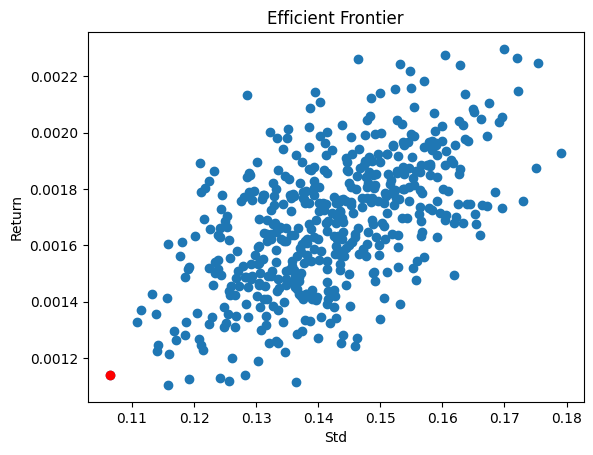

return of min portfolio stds:  0.0011393207647394812
minimum std:  0.1064940095586011
weights:  [2.72816298e-02 4.53626129e-05 2.34803509e-02 3.75333062e-02
 3.77100888e-02 2.05570141e-02 5.05924275e-03 4.02415946e-02
 2.54301314e-02 2.93354418e-02 3.18038266e-02 1.02809609e-02
 1.63611295e-02 5.08111016e-03 3.14401538e-02 2.22175991e-02
 2.67539924e-02 6.21219098e-03 3.65900810e-02 2.94633607e-02
 3.26043197e-02 3.65963785e-03 2.62308972e-02 2.48712449e-02
 4.56138442e-03 2.75011342e-02 5.73592837e-03 3.32377883e-02
 4.82685237e-03 1.78679563e-02 1.89984996e-02 1.74822952e-02
 1.97254099e-02 8.34973641e-04 1.02885083e-02 2.75786779e-02
 1.69404454e-02 3.36628842e-02 8.91993510e-03 1.28152747e-02
 2.15473781e-03 9.55842876e-03 1.69351116e-02 6.56143667e-03
 3.23994489e-02 1.08153696e-02 1.74775306e-02 1.89993093e-02
 3.84188924e-02 3.54571186e-02]


In [52]:
# Efficient Frontier
num = 500
df = getLogReturnByStockPrice(df_previous_for_weighting)
returns = []
stds = []
w = []
for _ in range(num):
    weights = weightsCreator(df)
    
    returns.append(portfolioReturn(df, weights)) # weighted return
    stds.append(portfolioStd(df, weights, 250)) # portfolio stadnard deviation vector calc
    w.append(weights)

min_std = min(stds)
index_min = stds.index(min_std)
plt.scatter(stds, returns)
plt.scatter(min(stds), returns[stds.index(min(stds))], color="red")
plt.title("Efficient Frontier")
plt.xlabel("Std")
plt.ylabel("Return")
plt.show()

min_std = min(stds)
index_min = stds.index(min_std)
print("return of min portfolio stds: ", returns[index_min])
print("minimum std: ", min_std)
print("weights: ", w[index_min])